<a href="https://colab.research.google.com/github/asarria48/ML-for-materials/blob/main/AI4Spec_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI4Spec 1: Predicting individual energy levels with kernel methods

In these tutorials exercises, we review different AI approaches to predicting ground or excited state energy levels simply based on the atomic structure of materials. Here we focus on molecules and molecular orbitals, but the sample principles apply to crystal structures and electronic bands.

We start by predicting individual electronic states (Tutorial 1), proceed towards predicting multiple states at once (Tutorial 2) and finish by predicting entire spectral curves (Tutorial 3). The tutorials were prepared by Milica Todorović (University of Turku) and Kunal Ghosh (Aalto University).

<img src="https://raw.githubusercontent.com/milicasan/TutorialImages/89238bfff57a38ec78ecbd08765b63bd15ff9e2c/AI4spec.png" width="600px"/>

In the exercise below, our AI objective is to train a model to predict a single electronic energy level, HOMO for example. This is a classic example of supervised machine learning regression, where the objective (label) is a single floating-point number. Many AI models can address this task, from decision trees, via kernel-based learning to neural networks. Here, we demonstrate the use of Kernel Ridge Regression, a relatively simple regression approach that has performed well on numerous prediction tasks in physics and chemistry and is [well explained in the literature](https://onlinelibrary.wiley.com/doi/10.1002/qua.24954).

We use a large dataset of molecular structures and their computed HOMO energies to train the AI. Once the model is trained, it can be used as a tool: one can input a new molecule (previously unseen by the model) and instantly receive a value for its HOMO, within the expected error of the trained model.







## 1. HOMO energy prediction with kernel ridge regression


Here we will machine-learn the relationship between molecular structure (represented by the Coulomb matrix CM) and their HOMO (Highest Occupied Molecular Orbital) energy using KRR.

This tutorial shows step by step how to load the data, visualize them, select the hyperparameters, train the model and validate it. We use the QM7 dataset of 7000 small organic molecules. The HOMO energies of all molecules were pre-computed with first principles quantum mechanical methods (DFT) to obtain the target data that our model can be trained on. Detailed descriptions and results for a similar dataset (QM9) can be found in [A. Stuke, et al. "Chemical diversity in molecular orbital energy predictions with kernel ridge regression." J. Chem. Phys. 150. 204121 (2019)](https://aip.scitation.org/doi/10.1063/1.5086105).


## Setup

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import math, random
from scipy.sparse import load_npz
from matplotlib.colors import LinearSegmentedColormap
import time

### Load and visualize data

At first, we load the data.

The input data x is an array that contains all 7000 molecules of the QM7 dataset, represented by their Coulomb matrices, which were computed with the [Dscribe](https://www.sciencedirect.com/science/article/pii/S0010465519303042?via%3Dihub) package.

The output data y is a list that contains the corresponding (pre-computed) HOMO energies.

In [2]:
!wget https://github.com/fullmetalfelix/ML-CSC-tutorial/raw/master/data/qm7/cm.npz
!wget https://raw.githubusercontent.com/fullmetalfelix/ML-CSC-tutorial/master/data/qm7/HOMO.txt

--2025-10-17 20:25:00--  https://github.com/fullmetalfelix/ML-CSC-tutorial/raw/master/data/qm7/cm.npz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fullmetalfelix/ML-CSC-tutorial/master/data/qm7/cm.npz [following]
--2025-10-17 20:25:01--  https://raw.githubusercontent.com/fullmetalfelix/ML-CSC-tutorial/master/data/qm7/cm.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3638980 (3.5M) [application/octet-stream]
Saving to: ‘cm.npz’

cm.npz              100%[===================>]   3.47M  16.5MB/s    in 0.2s    

2025-10-17 20:25:02 (16.5 MB/s) - ‘cm.npz’ saved [3638980/3638980]

--2025-10-1

In [3]:
x = load_npz("cm.npz").toarray()
y = np.genfromtxt("HOMO.txt")

print("Number of molecules:", len(y))

Number of molecules: 6926


Print the Coulomb matrix of a random molecule in the dataset.

In [4]:
rand_mol = random.randint(0, len(y))

print(x[rand_mol])

[53.359 30.646 24.55  17.21  12.643 12.866 17.685  6.905  6.894  2.742
  2.142  1.653  1.83   1.611  2.437  1.791  0.     0.     0.     0.
  0.     0.     0.    30.646 36.858 39.115 23.577 14.099 11.72  13.882
  2.933  2.895  2.769  2.825  1.72   2.117  1.461  2.124  1.473  0.
  0.     0.     0.     0.     0.     0.    24.55  39.115 73.517 19.834
 14.704 12.277 14.071  3.19   2.524  2.46   3.103  1.898  2.553  1.657
  2.29   1.541  0.     0.     0.     0.     0.     0.     0.    17.21
 23.577 19.834 36.858 23.359 13.941 16.155  1.783  2.325  5.46   5.471
  2.778  2.759  1.703  2.061  1.843  0.     0.     0.     0.     0.
  0.     0.    12.643 14.099 14.704 23.359 36.858 23.532 19.303  1.446
  1.847  2.76   2.77   5.442  5.449  2.764  2.762  2.223  0.     0.
  0.     0.     0.     0.     0.    12.866 11.72  12.277 13.941 23.532
 36.858 33.368  1.521  2.066  2.081  1.709  2.77   2.8    5.438  5.462
  3.044  0.     0.     0.     0.     0.     0.     0.    17.685 13.882
 14.071 16.155 19.3

Visualize the Coulomb matrix of the random molecule.

<Figure size 640x480 with 0 Axes>

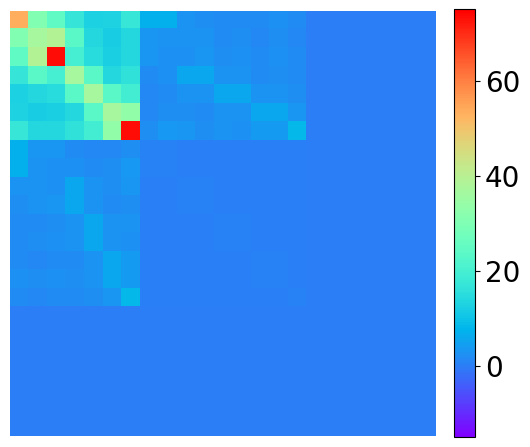

In [5]:
shape = (23, 23)
mat = x[rand_mol].reshape(shape)

plt.figure()
plt.figure(figsize = (6,6))
plt.imshow(mat, origin="upper", cmap='rainbow', vmin=-15, vmax=75, interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=20)
plt.axis('off')
plt.show()

Note that many of the outputs are zero in the Coulomb matrix. This is because the number of non-zero outputs depends on the size of the molecule, and all smaller molecules contain zero padding.

Visualize the target data by plotting the distribution of HOMO energies in the dataset:

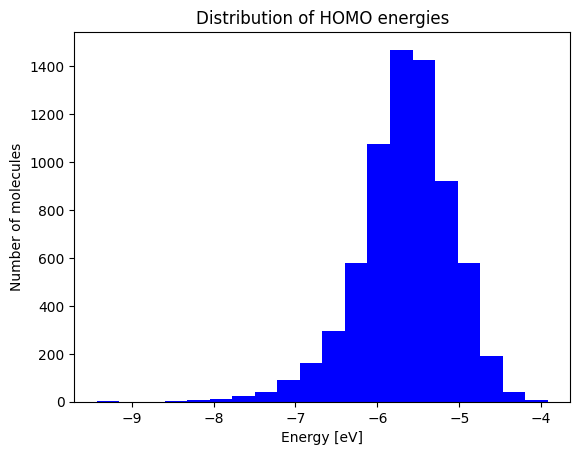

Mean value of HOMO energies in QM7 dataset: -5.66 eV


In [6]:
plt.hist(y, bins=20, density=False, facecolor='blue')
plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.title("Distribution of HOMO energies")
plt.show()

## mean value of distribution
print("Mean value of HOMO energies in QM7 dataset: %0.2f eV" %np.mean(y))

Before dividing the dataset into training and test set, we shuffle the data. This is because data are often stored in a logical order (e.g., certain types of molecules grouped one after each other). Simply taking the first part for training and the second for testing would not result in a well trained model, since the training set would not represent the test data well (and vice versa).

In [7]:
## shuffle the data

c = list(zip(x, y))
random.shuffle(c)

x, y = zip(*c)

x = np.array(x)
y = np.array(y)

Now, we divide the data into training and test set.

In [8]:
# decide how many samples to take from the database for training and testing
n_train = 1000
n_test = 1000

# split data in training and test
# take first n_train molecules for training
x_train  = x[0:n_train]
y_train = y[0:n_train]

# take the next n_test data for testing
x_test = x[n_train:n_train + n_test]
y_test = y[n_train:n_train + n_test]

Check that the training data resemble the test data well by plotting the distribution of HOMO energies for both sets. The distributions should be centered around the same mean value and have the same shape.

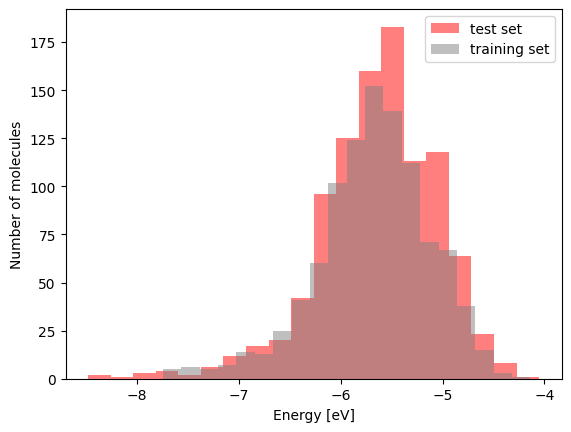

Mean value of HOMO energies in training set: -5.68 eV
Mean value of HOMO energies in test set: -5.64 eV


In [9]:
plt.hist(y_test, bins=20, density=False, alpha=0.5, facecolor='red', label='test set')
plt.hist(y_train, bins=20, density=False, alpha=0.5, facecolor='gray', label='training set')
plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.legend()
plt.show()

## mean value of distributions
print("Mean value of HOMO energies in training set: %0.2f eV" %np.mean(y_train))
print("Mean value of HOMO energies in test set: %0.2f eV" %np.mean(y_test))

### Training

In the training phase we use a kernel function to measure the distance between all pairs of molecules (represented by their Coulomb matrices) in the training set. We here employ one of two kernels, the Gaussian kernel or the Laplacian kernel. Both kernels have two hyperparameters: $\alpha$ controls the penalty term and $\gamma$ the kernel width.

To find the optimal hyperparameters, we will do a grid search, i.e. we test the performance of a model trained with values of the hyperparameters that are spaced out on a grid in search space and choose the hyperparameters that yield the best performance.

The model performance is quantified by splitting off part of the training set as validation set. We validate the model by making predictions on this validation set. This check of the model performance can be further refined with cross-validation, where the roles of training and validation sets alternate. The ratio can be varied, for example in 5-fold cross-validation, the training set is split in 5 equal parts. The model is trained on 80% of the data and validated on the other 20%. Then the roles of training and validation set rotate until each part has served as validation set exactly once.

For our implementation, we will use the scikit-learn module.

A more detailed optional explanation, which is not required for the solution of the exercise, can be found in the hidden cell below.

The Gaussian kernel is given by

\begin{equation}
k_{Gaussian}(\boldsymbol{x},\boldsymbol{x}')=e^{-\frac{||{\boldsymbol{x}-\boldsymbol{x}'}||_2^2}{2\gamma^2}},
\end{equation}

which employs the Euclidean distance as similarity measure. The parameter $\gamma$ is defined as $\frac{1}{2\sigma^2}$, where $\sigma$ is the standard deviation of the Gaussian kernel (kernel width). The Laplacian kernel is given by

\begin{equation}
    k_{Laplacian}(\boldsymbol{x},\boldsymbol{x}')=e^{-\frac{||{\boldsymbol{x}-\boldsymbol{x}'}||_1}{\gamma}},
\end{equation}

which uses the 1-norm as similarity measure. Here, $\gamma$ is defined as $\frac{1}{\sigma}$, where $\sigma$ is the kernel width of the Laplacian kernel.

In the KRR training phase with $N$ training molecules, the machine learns the relationship between the molecules (represented by their Coulomb matrix) and their corresponding (pre-computed) HOMO energies. It does so by employing a function $f(\boldsymbol{x})$ that maps a training molecule $\boldsymbol{x}$ to its reference HOMO energy:

\begin{equation}
f(\boldsymbol{x}) = \sum_{i=1}^N \omega_i k(\boldsymbol{x}, \boldsymbol{x}_i) = HOMO^{ref},
\end{equation}

For a given training molecule $\boldsymbol{x}$, the distance to each molecule in the training set is computed by employing the kernel function $k$ (either Gaussian or Laplacian). Each kernel contribution (distance) is then weighted by a regression weight $\omega_i$. The above function is thus given by the weighted sum of kernel contributions (sum over $N$ training molecules). The purpose of training is to fit the regression weight $\omega_i$ so that HOMO$_{ref}$ is matched for each training molecule. In practice, the machine solves the minimization problem


\begin{equation}
 \underset{\omega}{min} \sum_{i=1}^N (f(\boldsymbol{x}_i) - HOMO^{ref}_i)^2 + \alpha \boldsymbol{\omega}^T \mathbf{K} \boldsymbol{\omega}.
\end{equation}

for a vector $\boldsymbol{\omega} \in \mathbb{R}^N = (\omega_1, \omega_2, ..., \omega_N)$ of regression weights. In KRR, the penalty term $ \alpha \boldsymbol{\omega}^T \mathbf{K} \boldsymbol{\omega}$ is added to the minimization problem in order to avoid over- and underfitting. Overfitting occurs when the model learns the training data too well, even the noise and other unimportant details. The model is unable to generalize on unseen data and therefore yields high prediction errors on the test data. Underfitting occurs when the model is too simple and does not learn the training data at all, and therefore is not able to predict test data well either. Both behaviours can be avoided by tuning the parameter $\alpha \in \left[0,1\right]$ to a reasonable value. This has do be done separately from training. Both the regularization parameter $\alpha$ and the kernel width $\gamma$ are so called hyperparameters. Hyperparameters cannot be learned during training and have to be selected beforehand. However, it is not always obvious how to choose these hyperparameters and it often requires intuition or rules of thumb. We here employ a cross-validated grid search in order to find the best values for these two hyperparameters.

In grid search, a part of the training set is split off as validation set. We set up a grid of pre-defined hyperparameter values and train the machine on the remaining training set, for each possible combination of $\alpha$ and $\gamma$ values. We validate each possible combination by making predictions on the validation set. The two hyperparameter values that yield the best performance (lowest error) are then selected for the final model to make predictions on the test set.

In cross-validation, the roles of training and validation sets alternate. As described above, a part from the training set is split off as validation set. After training one combination of hyperparameters on the remaining training set and validating on the validation set, the validation set becomes the training set and vice versa, and the model is trained on the new training set and validated on the new validation set for the same combination of hyperparameters. The ratio can be varied, for example in 5-fold cross-validation, the training set is split in 5 equal parts. For each combination of hyperparameters, the model is trained on 80% of the data and validated on the other 20%. Then the roles of training and validation set rotate until each part has served as validation set exactly once. The final validation error for one particular combination of hyperparameters is computed as the mean from all 5 errors on the 5 validation sets. The combination with lowest average error is chosen for the final model.

The cross-validated grid search routine is implemented in scikit-learn.

### KRR Code

In [10]:
# set up grids for alpha and gamma hyperparameters.
# first value: lower bound; second value: upper bound;
# third value: number of points to evaluate (here set to '3' --> '-2', '-1' and '0' are evaluated)
# --> make sure to change third value as well when changing the bounds!
alpha = np.logspace(-4, -2, 3)
gamma = np.logspace(-4, -2, 3)

cv_number = 2 ## choose into how many parts training set is divided for cross-validation
kernel = 'laplacian' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                             # highest scoring value as best, but we want small errors

## define settings for grid search routine in scikit-learn with above defined grids as input

grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search
                                          # routine so we can see what is computed

# call the fit function in scikit-learn which fits the Coulomb matrices in the training set
# to their corresponding HOMO energies.
grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2; 1/9] START alpha=0.0001, gamma=0.0001, kernel=laplacian................
[CV 1/2; 1/9] END alpha=0.0001, gamma=0.0001, kernel=laplacian;, score=-0.296 total time=   0.3s
[CV 2/2; 1/9] START alpha=0.0001, gamma=0.0001, kernel=laplacian................
[CV 2/2; 1/9] END alpha=0.0001, gamma=0.0001, kernel=laplacian;, score=-0.300 total time=   0.3s
[CV 1/2; 2/9] START alpha=0.0001, gamma=0.001, kernel=laplacian.................
[CV 1/2; 2/9] END alpha=0.0001, gamma=0.001, kernel=laplacian;, score=-0.286 total time=   0.3s
[CV 2/2; 2/9] START alpha=0.0001, gamma=0.001, kernel=laplacian.................
[CV 2/2; 2/9] END alpha=0.0001, gamma=0.001, kernel=laplacian;, score=-0.307 total time=   0.3s
[CV 1/2; 3/9] START alpha=0.0001, gamma=0.01, kernel=laplacian..................
[CV 1/2; 3/9] END alpha=0.0001, gamma=0.01, kernel=laplacian;, score=-1.577 total time=   0.3s
[CV 2/2; 3/9] START alpha=0.0001, gamma=0.01, kernel=l

GridSearchCV(cv=2, estimator=KernelRidge(),
             param_grid=[{'alpha': array([0.0001, 0.001 , 0.01  ]),
                          'gamma': array([0.0001, 0.001 , 0.01  ]),
                          'kernel': ['laplacian']}],
             scoring='neg_mean_absolute_error', verbose=1000)

### Grid search results

Print out the average validation errors and corresponding hyperparameter combinations

In [11]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(-means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.298 (+/-0.004) for {'alpha': np.float64(0.0001), 'gamma': np.float64(0.0001), 'kernel': 'laplacian'}
0.296 (+/-0.021) for {'alpha': np.float64(0.0001), 'gamma': np.float64(0.001), 'kernel': 'laplacian'}
1.540 (+/-0.075) for {'alpha': np.float64(0.0001), 'gamma': np.float64(0.01), 'kernel': 'laplacian'}
0.293 (+/-0.002) for {'alpha': np.float64(0.001), 'gamma': np.float64(0.0001), 'kernel': 'laplacian'}
0.296 (+/-0.021) for {'alpha': np.float64(0.001), 'gamma': np.float64(0.001), 'kernel': 'laplacian'}
1.541 (+/-0.075) for {'alpha': np.float64(0.001), 'gamma': np.float64(0.01), 'kernel': 'laplacian'}
0.287 (+/-0.008) for {'alpha': np.float64(0.01), 'gamma': np.float64(0.0001), 'kernel': 'laplacian'}
0.296 (+/-0.020) for {'alpha': np.float64(0.01), 'gamma': np.float64(0.001), 'kernel': 'laplacian'}
1.548 (+/-0.076) for {'alpha': np.float64(0.01), 'gamma': np.float64(0.01), 'kernel': 'laplacian'}


Next, we visualize the grid search results by plotting a heatmap.

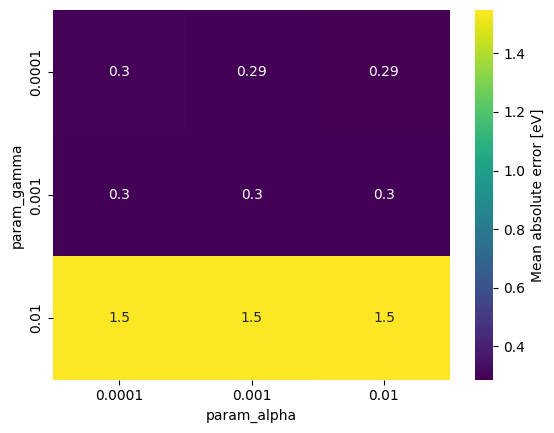

The best combinations of parameters are {'alpha': np.float64(0.01), 'gamma': np.float64(0.0001), 'kernel': 'laplacian'} with a score of 0.287 eV on the validation set.


In [12]:
results = pd.DataFrame(grid_search.cv_results_)
#pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()


print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

### Testing

With the best combination of hyperparameters, the model is once again trained on the entire training set (this is done automatically in scikit-learn). Then, with the best combination of hyperparameters, predictions are made on the test set to evaluate the final model, which we will use for predictions.

The mean absolute error of the predicted from the reference HOMO energies and $R^2$ score will be our measure for the quality of the fit.


Mean absolute error on test set: 0.266 eV


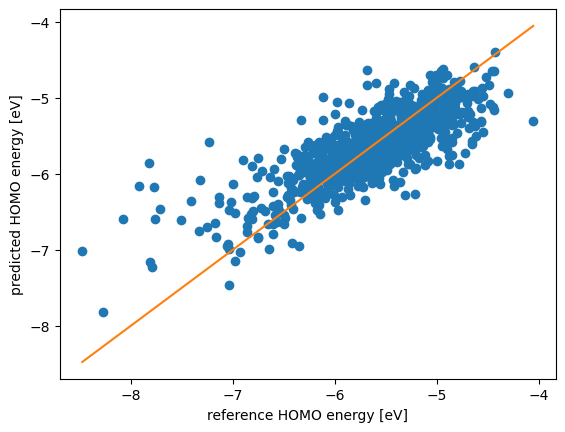

R^2 score on test set: 0.615


In [13]:
# predicted HOMO energies for all test molecules

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                     # of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

# do the regression plot
plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

The $R^2$ score indicates how close the predicted energies in the test set are to the reference energies. The closer the points in the above figure are located to the diagonal, the better the predictions. Points on the diagonal ("predicted energy"="reference energy") correspond to $R^2=1$. Therefore, $R^2$ values close to 1 indicate good model performance.

###**Exercises**

#### a. Grid search

Increase the number and range of grid points used for grid search. Which combination of $\alpha$ and $\gamma$ works best? How does the computational time increase? Choose a reasonable number of grid points that don't take too long to evaluate.

Fitting 2 folds for each of 121 candidates, totalling 242 fits
[CV 1/2; 1/121] START alpha=1e-11, gamma=1e-11, kernel=laplacian................
[CV 1/2; 1/121] END alpha=1e-11, gamma=1e-11, kernel=laplacian;, score=-0.308 total time=   0.6s
[CV 2/2; 1/121] START alpha=1e-11, gamma=1e-11, kernel=laplacian................
[CV 2/2; 1/121] END alpha=1e-11, gamma=1e-11, kernel=laplacian;, score=-0.309 total time=   0.6s
[CV 1/2; 2/121] START alpha=1e-11, gamma=1e-10, kernel=laplacian................
[CV 1/2; 2/121] END alpha=1e-11, gamma=1e-10, kernel=laplacian;, score=-0.310 total time=   0.7s
[CV 2/2; 2/121] START alpha=1e-11, gamma=1e-10, kernel=laplacian................
[CV 2/2; 2/121] END alpha=1e-11, gamma=1e-10, kernel=laplacian;, score=-0.311 total time=   0.4s
[CV 1/2; 3/121] START alpha=1e-11, gamma=1e-09, kernel=laplacian................
[CV 1/2; 3/121] END alpha=1e-11, gamma=1e-09, kernel=laplacian;, score=-0.310 total time=   0.3s
[CV 2/2; 3/121] START alpha=1e-11, gamma=1e-09,

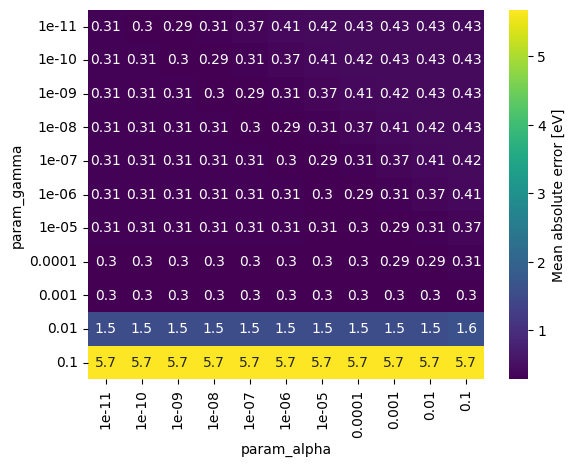

The best combinations of parameters are {'alpha': np.float64(0.01), 'gamma': np.float64(0.0001), 'kernel': 'laplacian'} with a score of 0.287 eV on the validation set.
Mean absolute error on test set: 0.266 eV


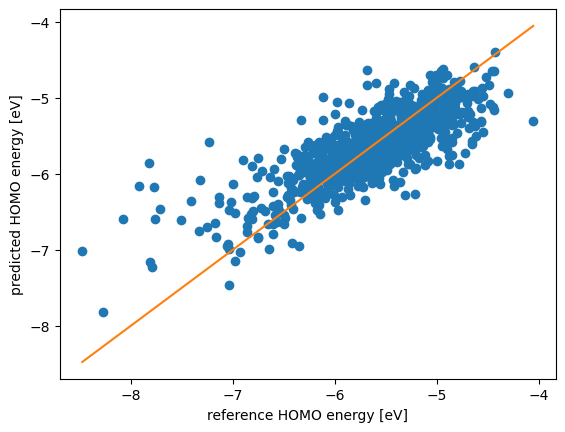

R^2 score on test set: 0.615


In [17]:
#Choose alpha and gamma on a finer logarithmically spaced grid. The other parameters can be chosen as above.
alpha = None
gamma = None
cv_number=None
kernel = None
scoring_function = None

# set up grids for alpha and gamma hyperparameters.
# first value: lower bound; second value: upper bound;
# third value: number of points to evaluate (here set to '3' --> '-2', '-1' and '0' are evaluated)
# --> make sure to change third value as well when changing the bounds!
alpha = np.logspace(-11, -1, 11)
gamma = np.logspace(-11, -1, 11)

cv_number = 2 ## choose into how many parts training set is divided for cross-validation
kernel = 'laplacian' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                             # highest scoring value as best, but we want small errors



grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search routine

grid_search.fit(x_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()

print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

#### b. Kernel function

Use the Gaussian kernel instead of the Laplacian kernel. Which kernel leads to better model performance?

In [18]:
#Repeat the above calculation with the Gaussian kernel. The Gaussian kernel is identified with the string 'rbf'.
alpha = None
gamma = None
cv_number=None
kernel = None
scoring_function = None

grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search routine

grid_search.fit(x_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()

print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

TypeError: Parameter grid for parameter 'alpha' needs to be a list or a numpy array, but got None (of type NoneType) instead. Single values need to be wrapped in a list with one element.

#### c. Cross-validation

For this exercise, choose the kernel that performed better in the previous exercise. Increase the number of folds used for cross-validation. Does the quality of the model increase? Take note as well of the increasing computational time and choose a number of folds that does not require too much computational time.

In [ ]:
#Repeat the above calculation with a higher number of cross-validation folds. Use the kernel that showed better performance.
alpha = None
gamma = None
cv_number=None
kernel = None
scoring_function = None

grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search routine

grid_search.fit(x_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
#pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()

print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

#### d. Training set size

Increase the size of the training set and plot the mean absolute error and $R^2$ score and training time on the test set as a function of the training set size (e.g. use 1000, 2000, 3000 etc. as training set size). For the MAE and $R^2$ values use a logarithmic time axis. Compare with the previous exercises.

The optimal hyperparameter values for $\alpha$ and $\gamma$ can change throughout varying training set sizes. Therefore, when increasing the training set size, it is recommended to perform a cross-validated grid search for each training set size. For the sake of this exercise, we will limit ourselves to taking the optimal hyperparameters from the previous exercise as an approximation and not perform a grid search. Furthermore, we will not cross-validate our model in this exercise in the interest of time.

In [19]:
#We keep the size of the test set constant in this exercise
n_test = 1000

#We want to iterate over different training set sizes n_train.
#Prepare an iterator with reasonable choices of n_train.
n_train_iterator=range(None,None,None)

#These lists we want to fill during the iteration with the mean absolute error,
#R^2 score and elapsed training time.
mae_list=[]
r2_list=[]
time_list=[]

#In alpha and gamma, we want to save the best choice of parameters from
#the previous exercise. Compare with the exercise above, if you are unsure
#how to access them from grid_search.
alpha=None
gamma=None

#Use the kernel that has shown better performance.
kernel=None

for n_train in n_train_iterator:
  x_train  = x[0:n_train]
  y_train = y[0:n_train]

  x_test = x[n_train:n_train + n_test]
  y_test = y[n_train:n_train + n_test]

  #Here we save the starting time of the kernel ridge training.
  start = time.time()

  #In the following we will perform the kernel ridge training without
  #cross-validation. For this we use the Object KernelRidge, which
  #has previously been used as the estimator in the cross-validation.
  #We need to set alpha, gamma and the kernel. For documentation, see:
  #https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
  kernel_ridge=None

  #After settung up the kernel_ridge object, we need to train with our
  #training data using the method fit and make predictions on the test set
  #using the method predict in analogy to the cross-validation example.

  #Fill in your answer here!

  #Here we save the ending time of the kernel ridge training.
  end = time.time()

  #Compute from the starting and ending time, the elapsed training time and
  #append it to the list
  time_list.append(None)
  #Append the mean absolute error to the following list. Confer with the
  #previous exercise, if you are unsure how to compute it.
  mae_list.append(None)
  r2_list.append(r2_score(y_test, y_pred))

#In the following plot the size of the training set versus the elapsed time,
#mean absolute error and R^2 score in three separate plots.

#Fill in your answer here!

#Here we plot the exact vs. the predicted HOMO energies for our largest training
#set size. Can you see the reduced error from this plot in comparison with
#the previous exercises?
plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()

TypeError: 'NoneType' object cannot be interpreted as an integer

#####If you did everything correctly, the plots should look something like the following. Note that because of the random data shuffling in the beginning, they will not look exactly the same.

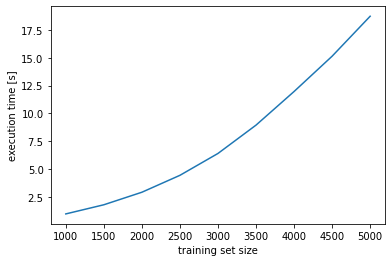

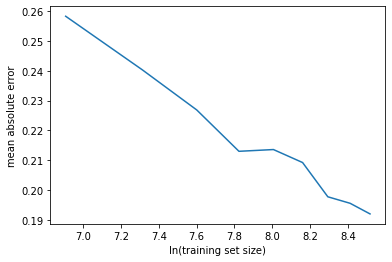

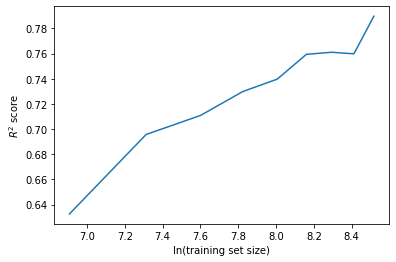

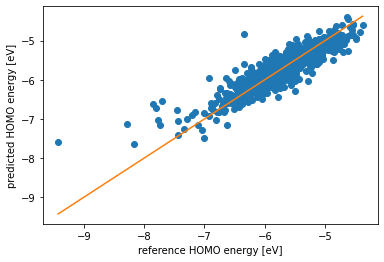